<a href="https://colab.research.google.com/github/soyeunju/ESAA/blob/main/25-1/Assignments/0523_Week12_HW_DLWP_CNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📊딥러닝 파이토치 교과서 ch 5.3

p.200~229

## 5.3 전이 학습
* 전이 학습은 이미지넷(ImageNet)처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것을 의미
* 이때 아주 큰 데이터셋을 시용하여 훈련된 모델을 **사전 훈련된 모델(네트워크)**라고 함.
* 결과적으로 비교적 적은 수의 데이터를 가지고도 우리가 원하는 과제를 해결할 수 있음
* 전이 학습을 위한 방법으로는 **특성 추출**과 **미세 조정 기법**이 있음

### 5.3.1 특성 추출 기법
* 특성 추출(feature extraction)은 ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후에 마지막에 완전연결층 부분만 새로 만듦.
* 즉, 학습할 때는 마지막 완전연결층(이미지의 카테고리를 결정하는 부분)만 학습하고 나머지 계층들은 학습되지 않도록 함.
* 합성곱층: 합성곱층과 풀링층으로 구성
* 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분
* 사용 가능한 이미지 분류 모델은 다음과 같음
  * Xception
  * Inception V3
  * ResNet50
  * VGG16
  * VGG19
  * MobileNe
    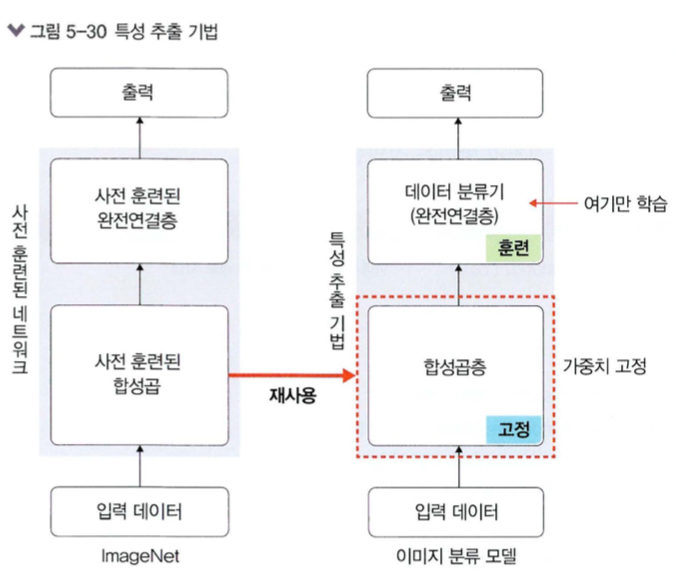


In [1]:
pip install opencv-python

In [8]:
# 라이브러리 호출
import os
import time
import copy
import glob
import cv2 # 앞에서 설치한 OpenCV 라이브러리
import shutil

import torch
import torchvision # 컴퓨터 비전(Computer Vision) 용도의 패키지
import torchvision.transforms as transforms # 데이터를 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있게 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 1. 저장소 전체를 clone
!git clone https://github.com/gilbutITbook/080289.git

# 2. 작업 디렉토리를 해당 폴더로 이동
%cd 080289/chap05/data/catanddog/

# 3. 파일 목록 확인
!ls

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 27 (delta 3), pack-reused 2246 (from 1)
Receiving objects: 100% (2278/2278), 330.30 MiB | 32.41 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.
/content/080289/chap05/data/catanddog
test  train


In [4]:
# 이미지 데이터 전처리 방법 정의
data_path = '/content/080289/chap05/data/catanddog/train'   # 이미지 데이터가 위치한 경로 지정

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])   # 1
train_dataset = torchvision.datasets.ImageFolder(
                data_path,
                transform=transform
)    # 2
train_loader = torch.utils.data.DataLoader(
               train_dataset,
               batch_size=32,
               num_workers=8,
               shuffle=True
)    # 3

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  ```
  1. torchvision.transform: 이미지 데이터를 변환하여 모델(네트워크)의 입력으로 시용할 수 있 게 변환해 줌.

  (a) Resize: 이미지의 크기를 조정. 256x256 크기로 이미지 데이터를 조정
  (b) RandomResizedCrop: 이미지를 랜덤한 크기 및 비율로 자름
      Resize: 합성곱층을 통과하기 위해 이미지 크기를 조정하는 전처리 과정
      RandomResizedCrop: 데이터 확장 용도로 사용. 이미지를 랜덤한 비율로 자른 후 데이터 크기를 조정
  (c) RandomHorizontalFlip: 이미지를 랜덤하게 수평으로 뒤집음
  (d) ToTensor: 이미지 데이터를 텐서로 변환
  ```

  ```
  2. torchvision.datasets.ImageFolder: 데이터로더가 데이터를 불러올 대상과 방법(transform)을 정의
  (a) 첫 번째 파라미터: 불러올 데이터가 위치한 경로
  (b) transform: 이미지 데이터에 대한 전처리
  ```

  ```
  3. torch.utils.DataLoader
  (a) 첫 번째 파라미터: 데이터셋을 지정
  (b) batch_size: 한 번에 불러올 데이터 양을 결정하는 배치 크기를 설정
  (c) num_workers: 데이터를 불러올 때 하위 프로세스를 몇 개 사용할지 설정. 너무 많은 하위 프로세스 설정은 오류/메모리 부족 현상
  (d) shuffle: 데이터를 무작위로 설정할지 지정 (shuffle = True: 데이터를 무작위로 섞어 랜덤)
  ```

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


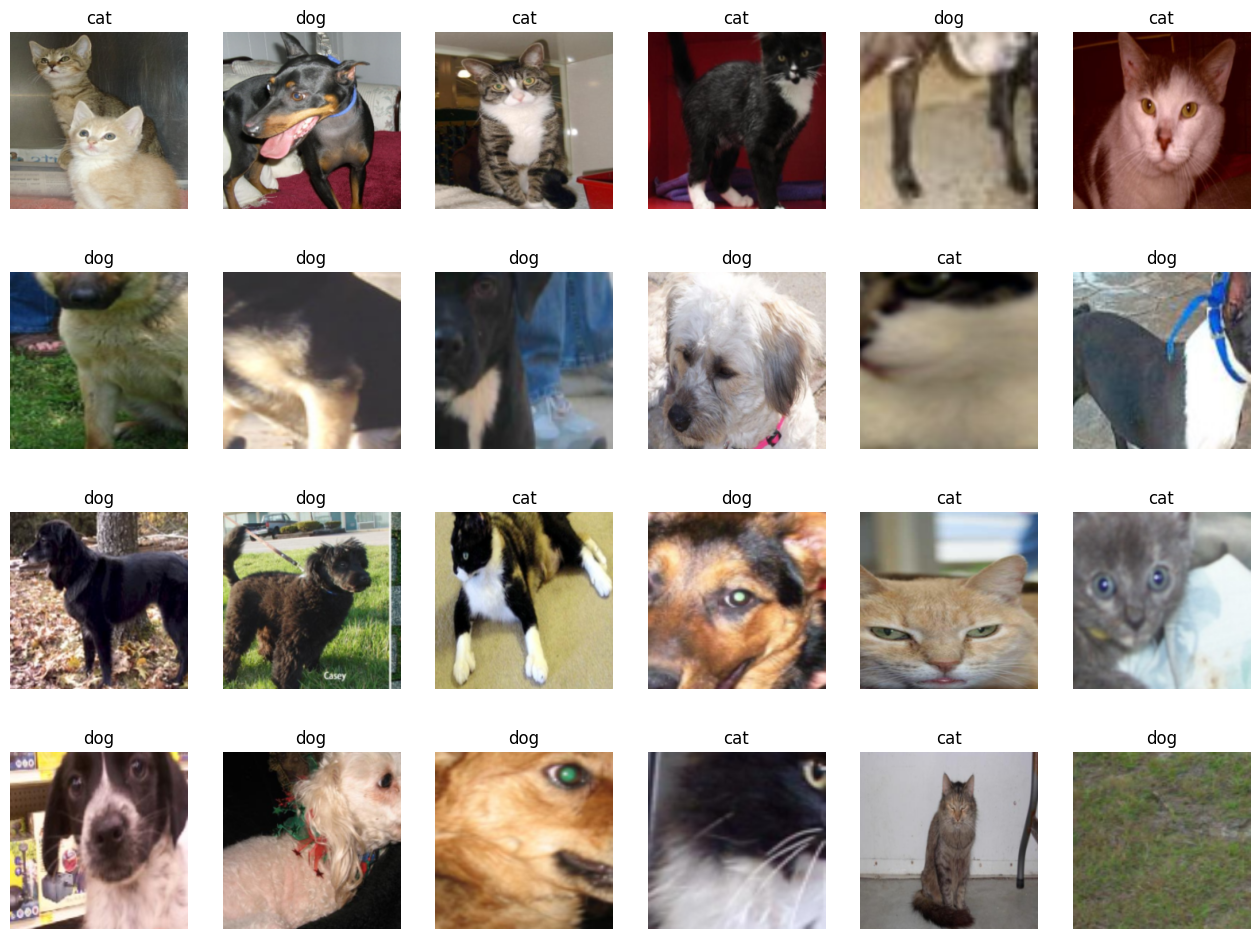

In [10]:
# 학습에 사용될 이미지 출력
samples, labels = next(iter(train_loader)) # 반복자와 같은 효과. iter()는 전달된 데이터의 반복자를 꺼내 반환하며 next()는 그 반복자가 다음에 출력해야 할 요소를 반환
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize = (16,24))
for i in range(24):
  a = fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off') #
  a.imshow(np.transpose(samples[i].numpy(),(1,2,0))) # np.transpose: 행렬 전치. torch.Size([3, 224, 224]) ➡️ (244,244,3)
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

In [11]:
print(samples.shape) # 32개의 이미지, 3채널, 244 x 244

torch.Size([32, 3, 224, 224])


In [13]:
# 사전 훈련된 모델 내려 받기
resnet18 = models.resnet18(pretrained=True) # pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.3MB/s]


* ResNet18
* ResNet18은 50개의 계층으로 구성된 합성곱 신경망. ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망으로 전이 학습에 사용되도록 사전 훈련된 모델을 제공하고 있음. 하지만 ResNet18은 입력 제약이 매우 크고, 충분한 메모리(RAM)가 없으면 학습 속도가 느렬 수 있는 단점이 있음.

In [14]:
# 사전 학습된 모델 파리미터 학습 유무 지정
def self_parameter_requires_grad(model, feature_extracting = True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False # 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음을 나타냄.

self_parameter_requires_grad(resnet18) # 내려받은 ResNet18의 합성곱층을 사용하되 파라미터에 대해서는 학습을 하지 않도록 고정

* `param.requires_grad = False`로 설정하여 모델의 일부(합성곱층 및 풀링)을 고정하고 나머지를 학습(완전연결층)
* 내려받은 ResNet18의 마지막 부분에 완전연결층을 추가. 추가된 완전연결층은 개와 고양이 클래스를 분류하는 용도로 시용.
  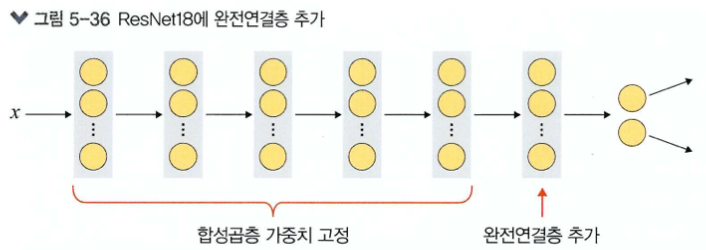

In [15]:
# ResNet18에 완전 연결층 추가
resnet18.fc = nn.Linear(512,2) # 2는 클래스가 두 개라는 의미

In [16]:
# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters(): # model.named_parametersO는 모델에 접근하여 파라미터 값들을 가져올 때 사용
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[ 0.0242, -0.0349,  0.0270,  ...,  0.0110, -0.0442,  0.0293],
        [ 0.0391, -0.0126, -0.0233,  ...,  0.0330, -0.0198,  0.0041]])
fc.bias tensor([-0.0043, -0.0290])


In [19]:
# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained = True) # 모델의 객체 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 고정
  param.requires_grad = False

model.fc = nn.Linear(512,2)
for param in model.fc.parameters(): # 완전연결층은 학습
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

* 내려받은 ResNet18 모델의 마지막에 완전연결층을 추가한 모델을 보여줌

In [30]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
  since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders: # 데이터로더에 전달된 데이터만큼 반복
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad() # 기울기를 0으로 설정
      outputs = model(inputs) # 순전파 학습
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs,1)
      loss.backward() # 역전파 학습
      optimizer.step()

      running_loss += loss.item()*inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
      running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

    epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
    epoch_acc = running_corrects / len(dataloaders.dataset) # 평균 정확도 계산

    print ('Loss: {: .4f} Acc: {: .4f}'.format (epoch_loss , epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(), os.path.join('/content/080289/chap05/data/catanddog/','{0:0=2d}.pth'.format(epoch)))   # 모델 재사용을 위해 저장.
    print()

  time_elapsed = time.time() - since  # 실행 시간(학습 시간)을 계산
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best Acc: {:.4f}'.format(best_acc))
  return acc_history, loss_history # 모델의 정확도와 오차를 반환

In [28]:
# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)   # 파라미터 학습 결과를 저장
        print("\t", name)

optimizer = optim.Adam(params_to_update)   # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [31]:
# 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loss:  0.4071 Acc:  0.7896

Epoch 1/12
----------
Loss:  0.2774 Acc:  0.9039

Epoch 2/12
----------
Loss:  0.2702 Acc:  0.8883

Epoch 3/12
----------
Loss:  0.2737 Acc:  0.8779

Epoch 4/12
----------
Loss:  0.2395 Acc:  0.9169

Epoch 5/12
----------
Loss:  0.2036 Acc:  0.9195

Epoch 6/12
----------
Loss:  0.2346 Acc:  0.8935

Epoch 7/12
----------
Loss:  0.2757 Acc:  0.8805

Epoch 8/12
----------
Loss:  0.2604 Acc:  0.8935

Epoch 9/12
----------
Loss:  0.2051 Acc:  0.9221

Epoch 10/12
----------
Loss:  0.1903 Acc:  0.9325

Epoch 11/12
----------
Loss:  0.2392 Acc:  0.8831

Epoch 12/12
----------
Loss:  0.1845 Acc:  0.9325

Training complete in 9m 17s
Best Acc: 0.9325


In [32]:
# 테스트 데이터 호출 및 전처리
test_path = '/content/080289/chap05/data/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [39]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/080289/chap05/data/catanddog/' + '*.pth')   # glob은 현재 디렉토리에서 원하는 파일들만 추출하여 가져올 때 사용
    saved_models.sort()   # 불러온 .pth 파일들을 정렬
    print('saved_model:', saved_models)

    for model_path in saved_models:
        print('loading model:', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in test_loader: # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad(): # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs)   # 데이터를 모델에 적용한 결과를 outputs에 저장

            _, preds = torch.max(outputs.data, 1) # torch.max는 주어진 텐서 배열의 최댓값이 들어 있는 index를 반환하는 함수
            preds[preds >= 0.5] = 1  # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds < 0.5] = 0   # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels.cpu()).int().sum() # preds.eq(labels)는 preds 배열과 labels가 일치하는지 검사히는 용도로 사용

        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 테스트 데이터의 정확도 계산
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
           best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                          time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history # 계산된 정확도 반환

In [40]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model: ['/content/080289/chap05/data/catanddog/00.pth', '/content/080289/chap05/data/catanddog/01.pth', '/content/080289/chap05/data/catanddog/02.pth', '/content/080289/chap05/data/catanddog/03.pth', '/content/080289/chap05/data/catanddog/04.pth', '/content/080289/chap05/data/catanddog/05.pth', '/content/080289/chap05/data/catanddog/06.pth', '/content/080289/chap05/data/catanddog/07.pth', '/content/080289/chap05/data/catanddog/08.pth', '/content/080289/chap05/data/catanddog/09.pth', '/content/080289/chap05/data/catanddog/10.pth', '/content/080289/chap05/data/catanddog/11.pth', '/content/080289/chap05/data/catanddog/12.pth']
loading model: /content/080289/chap05/data/catanddog/00.pth
Acc: 0.9490

loading model: /content/080289/chap05/data/catanddog/01.pth
Acc: 0.9388

loading model: /content/080289/chap05/data/catanddog/02.pth
Acc: 0.9592

loading model: /content/080289/chap05/data/catanddog/03.pth
Acc: 0.9592

loading model: /content/080289/chap05/data/catanddog/04.pth
Acc: 0.959

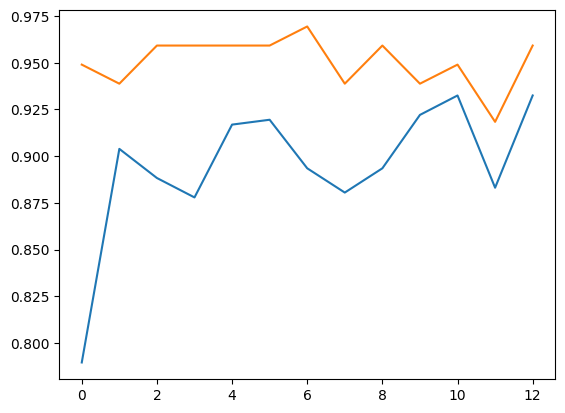

In [41]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

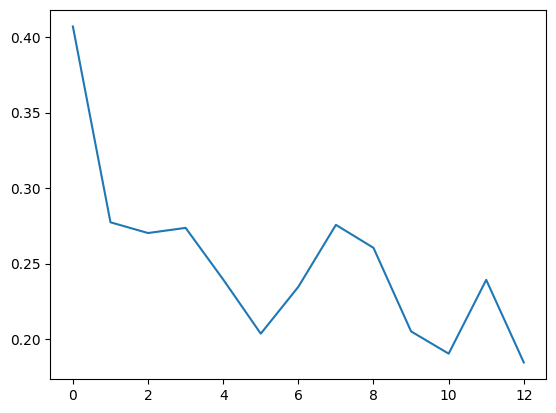

In [42]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [43]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # tensor.clone().detach()는 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에 영향을 주지는 않겠다는 의미
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)   # 2
    return image

`tensor.clone()`, `tensor.detach()`, `tensor.clone().detach()`의 비교

| 구분                     | 메모리       | 계산 그래프 상주 유무             |
|------------------------|-------------|----------------------------------|
| `tensor.clone()`        | 새롭게 할당  | 계산 그래프에 계속 상주            |
| `tensor.detach()`       | 공유해서 사용 | 계산 그래프에 상주하지 않음        |
| `tensor.clone().detach()` | 새롭게 할당  | 계산 그래프에 상주하지 않음        |

`clip()`: 입력 값이 주어진 범위를 벗어날 때 입력 값을 특정 범위로 제한시키기 위해 사용. 즉, `image.clip(0,1)`은 image 데이터를 0과 1 사이의 값으로 제한하겠다는 의미

In [48]:
# clip() 예시
exam = np.array([-1.8, -1.2, -0.7, 0.0, 0.8, 1.4, 1.9])
print(exam,'\n')
print(np.clip(exam, -0.5,0.5))

[-1.8 -1.2 -0.7  0.   0.8  1.4  1.9] 

[-0.5 -0.5 -0.5  0.   0.5  0.5  0.5]


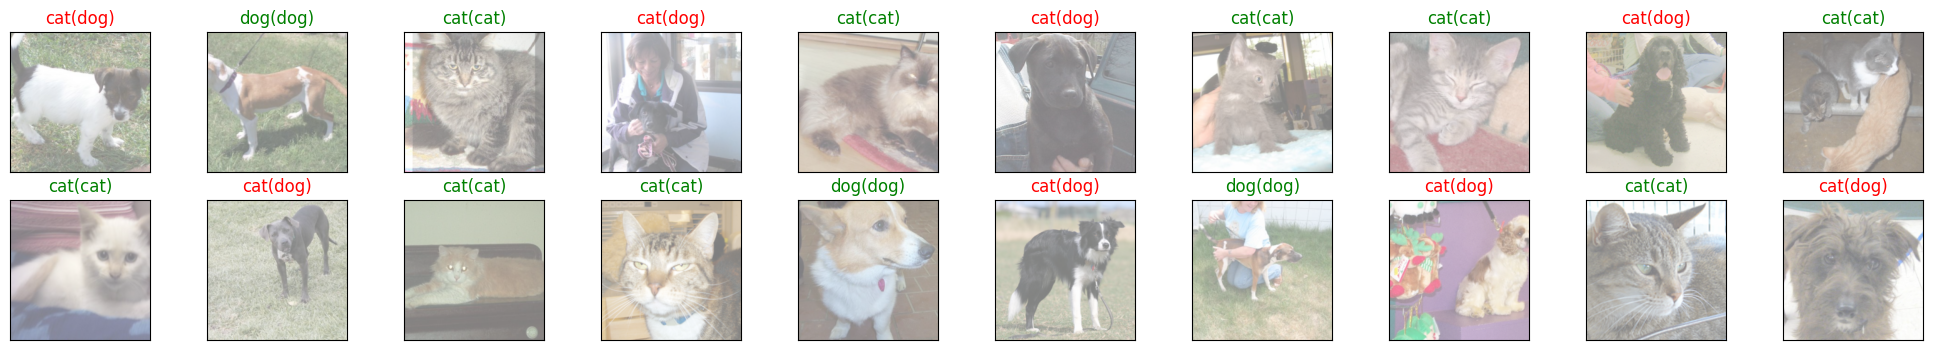

<Figure size 640x480 with 0 Axes>

In [51]:
# 개와 고양이의 예측 결과 출력
classes = {0: 'cat', 1: 'dog'} # 개와 고양이 두 개에 대한 레이블

dataiter = iter(test_loader) # 테스트 데이터셋을 가져온다
images, labels = next(dataiter) # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져 옴
output = model(images)
_, preds = torch.max(output,1)

fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks = [], yticks = []) # 행의 수, 열의 수, 인덱스, 틱을 삭제하겠다는 의미
  plt.imshow(im_convert(images[idx])) # 이미지 출력을 위해 코드 5-28에서 정의한 im_convert 함수를 적용
  a.set_title(classes[labels[i].item()])
  ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
  # classes[preds[idx].item()]은 preds[idx].item()값이 classes로 정의된 0괴 1중 어떤 값을 갖는지 판별하겠다는 의미.
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0) # hspace : 높이, wspace: 너비 조정

### 5.3 미세 조정 기법
* **미세 조정 (fine-tuning) 기법**은 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이 터 분류기의 가중치를 업데이트하여 훈련시키는 방식. 즉, 사전 학습된 모델을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습시키는 것. GPU 사용을 권장함

* **미세 조정 기법의 전략**

  * 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우: 모델 전체를 재학습.
  * 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우: 합성곱층의 뒷부분(완전연결층과 가까운 부분)과 데이터 분류기를 학습(강한 특징이 나타나는 부분).
  * 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우: 합성곱층의 일부분과 데이터 분류기를 학습.
  * 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우: 데이터 분류기만 학습.
* 미세 조정은 파라미터 업데이트 과정에서 파라미터에 큰 변화를 주게 되면 과적합 문제가 발생할 수 있기 때문에 정교하고 미세한 파라미터 업데이트가 필요

  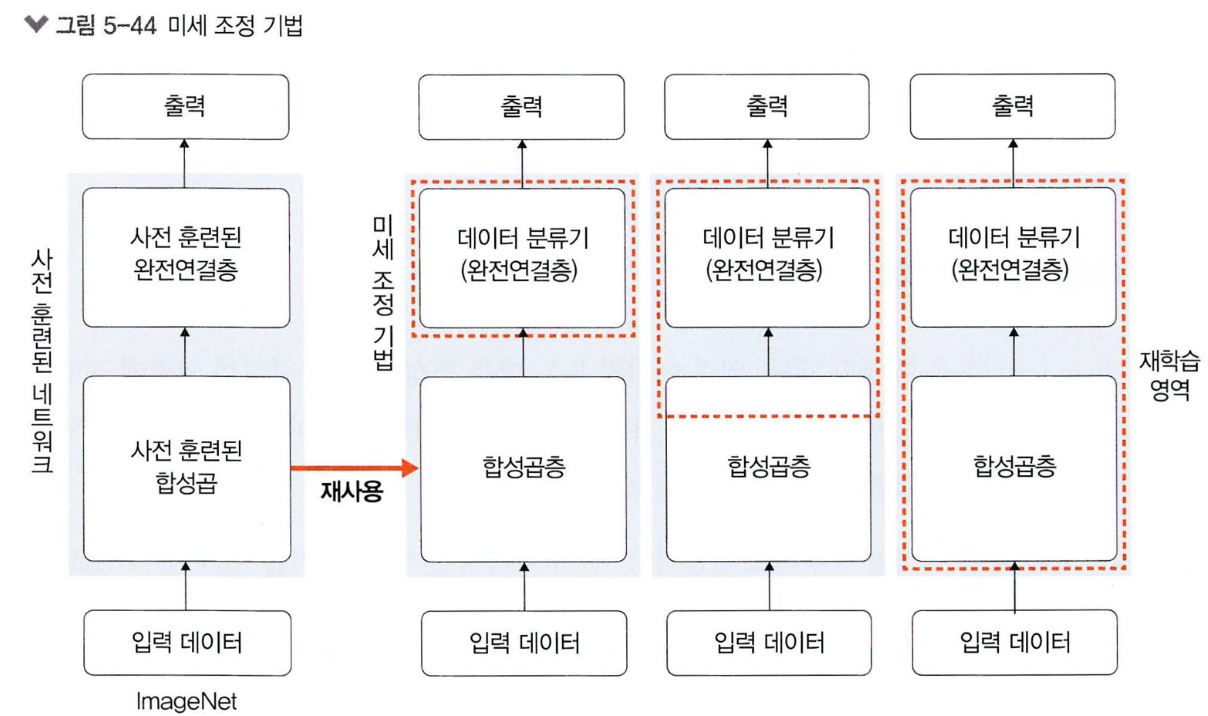